In [1]:
import gymnasium as gym
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)

### Setting up the environment

In [2]:
env = gym.make('MountainCar-v0')
env.action_space.seed(seed)

# print some information
print('Action space:', env.action_space)
print('Observation space:', env.observation_space)
print('Max episode steps:', env.spec.max_episode_steps)

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max episode steps: 200


### Set up network

In [3]:
class DQN(nn.Module):

    def __init__(self, input_dim, output_dim, epsilon_start, epsilon_end, epsilon_decay, env, device):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

        self.n_steps = 0
        self.epsilon_start, self.epsilon_end, self.epsilon_decay = epsilon_start, epsilon_end, epsilon_decay
        self.env = env

        self.device = device
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def act(self, state):
        self.n_steps += 1
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * self.n_steps / self.epsilon_decay)
        if random.random() > epsilon:
            with torch.no_grad():
                q_values = self.forward(state)
                action = q_values.max(1)[1].view(1, 1)
        else:
            action = torch.tensor([[random.randrange(self.env.action_space.n)]], dtype=torch.long, device=self.device)
        return action

In [4]:
from dqn import ReplayBuffer, train_dqn

# Hyperparams
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
tau = 0.99  # polyak averaging
gamma = 0.99

lr = 1e-3
batch_size = 64
buffer_size = 10000
eps_init, eps_final, eps_decay = 1.0, 0.01, 500  # exponential decay
n_episodes = 2500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
policy_net = DQN(
    input_dim=env.observation_space.shape[0],
    output_dim=env.action_space.n,
    epsilon_start=eps_init,
    epsilon_end=eps_final,
    epsilon_decay=eps_decay,
    env=env,
    device=device
).to(device)

target_net = DQN(
    input_dim=env.observation_space.shape[0],
    output_dim=env.action_space.n,
    epsilon_start=eps_init,
    epsilon_end=eps_final,
    epsilon_decay=eps_decay,
    env=env,
    device=device
).to(device)

In [6]:
optimizer = optim.AdamW(policy_net.parameters(), lr=lr)
criterion = nn.SmoothL1Loss()  # Huber loss
replay_buffer = ReplayBuffer(buffer_size)

In [7]:
policy_net, all_rewards, all_losses = train_dqn(
                                        policy_net,
                                        target_net,
                                        optimizer,
                                        criterion,
                                        env,
                                        n_episodes=n_episodes,
                                        replay_buffer=replay_buffer,
                                        tau=tau,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_freq=1,
                                        log_dir='./tensorboard',
                                        device=device,
                                        solved=(-110, 100)
                                    )

Training:  34%|███▎      | 838/2500 [09:20<18:32,  1.49it/s, Reward=-101, Loss=31]   

Solved in 838 episodes!


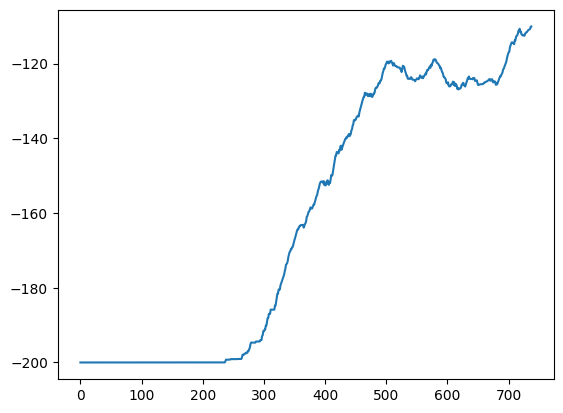

In [9]:
import matplotlib.pyplot as plt

window_size = 100
average_rewards = [sum(all_rewards[i:i+window_size])/window_size for i in range(len(all_rewards)-window_size)]

plt.plot(average_rewards)

As can be seen in the graph, the best mean reward (over a rolling window size of 100) is around -110 (at which point we stop the training, since the environment is considered solved).

In [10]:
from tqdm import tqdm

# evaluate the model
done = False
env.action_space.seed(seed=42)

total_rewards = []
n_test = 1000
for test_idx in tqdm(range(n_test)):
    state, _ = env.reset()
    done, total_reward = False, 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = policy_net.act(state)
        next_state, reward, terminated, truncated, _  = env.step(action.item())
        done = terminated or truncated
        env.render()
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)

env.close()

print('Total reward:', sum(total_rewards) / n_test)

  0%|          | 0/1000 [00:00<?, ?it/s]/DATA/charchit.sharma/miniconda3/envs/rl/lib/python3.12/site-packages/gymnasium/envs/classic_control/mountain_car.py:179: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(
100%|██████████| 1000/1000 [00:41<00:00, 24.07it/s]

Total reward: -102.045


In [15]:
actions = []
velocities = []
positions = []

n_test = 1
n_seeds = 10

for seed in range(n_seeds):
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    
    for test_idx in range(n_test):
        state, _ = env.reset()
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = policy_net.act(state)
            next_state, reward, terminated, truncated, _  = env.step(action.item())
            done = terminated or truncated
            actions.append(action.item())
            positions.append(state[0][0].item())
            velocities.append(state[0][1].item())
            state = next_state

env.close()

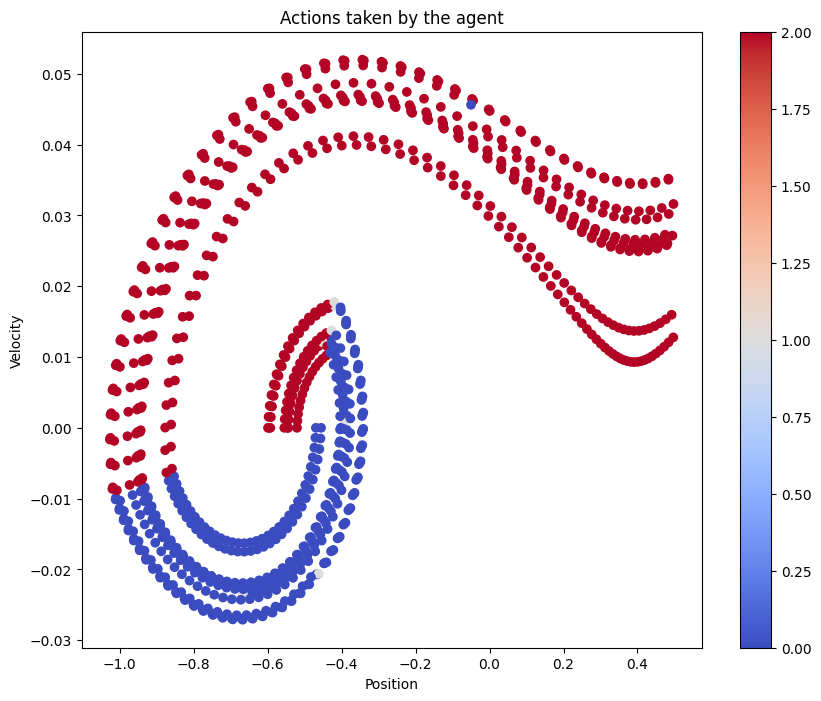

In [16]:
import numpy as np

actions = np.array(actions)
positions = np.array(positions)
velocities = np.array(velocities)

plt.figure(figsize=(10, 8))
plt.scatter(positions, velocities, c=actions, cmap='coolwarm')

plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Actions taken by the agent')
plt.colorbar()
plt.show()

Roughly, when the velocity is negative, push left, and when it is positive, push right. Keep increasing the momentum!

### Experimenting with hyperparameters

In [21]:
lrs = [1e-2, 1e-4, 1e-5]

# Keep the other hyperparameters the same
from dqn import ReplayBuffer, train_dqn

# Hyperparams
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
tau = 0.99  
gamma = 0.99

batch_size = 64
buffer_size = 10000
eps_init, eps_final, eps_decay = 1.0, 0.01, 500  
n_episodes = 2500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
all_experiment_rewards, all_experiment_losses = [], []
for lr in lrs:
    policy_net = DQN(
    input_dim=env.observation_space.shape[0],
    output_dim=env.action_space.n,
    epsilon_start=eps_init,
    epsilon_end=eps_final,
    epsilon_decay=eps_decay,
    env=env,
    device=device
    ).to(device)

    target_net = DQN(
        input_dim=env.observation_space.shape[0],
        output_dim=env.action_space.n,
        epsilon_start=eps_init,
        epsilon_end=eps_final,
        epsilon_decay=eps_decay,
        env=env,
        device=device
    ).to(device)
    
    optimizer = optim.AdamW(policy_net.parameters(), lr=lr)
    criterion = nn.SmoothL1Loss()  # Huber loss
    replay_buffer = ReplayBuffer(buffer_size)
    
    _, all_rewards, all_losses = train_dqn(
                                        policy_net,
                                        target_net,
                                        optimizer,
                                        criterion,
                                        env,
                                        n_episodes=n_episodes,
                                        replay_buffer=replay_buffer,
                                        tau=tau,
                                        batch_size=batch_size,
                                        gamma=gamma,
                                        target_update_freq=1,
                                        log_dir='./tensorboard',
                                        device=device,
                                        solved=(-110, 100)  
                                    )
    
    all_experiment_rewards.append(all_rewards)
    all_experiment_losses.append(all_losses)

Training: 100%|██████████| 2500/2500 [55:10<00:00,  1.32s/it, Reward=-200, Loss=103] 


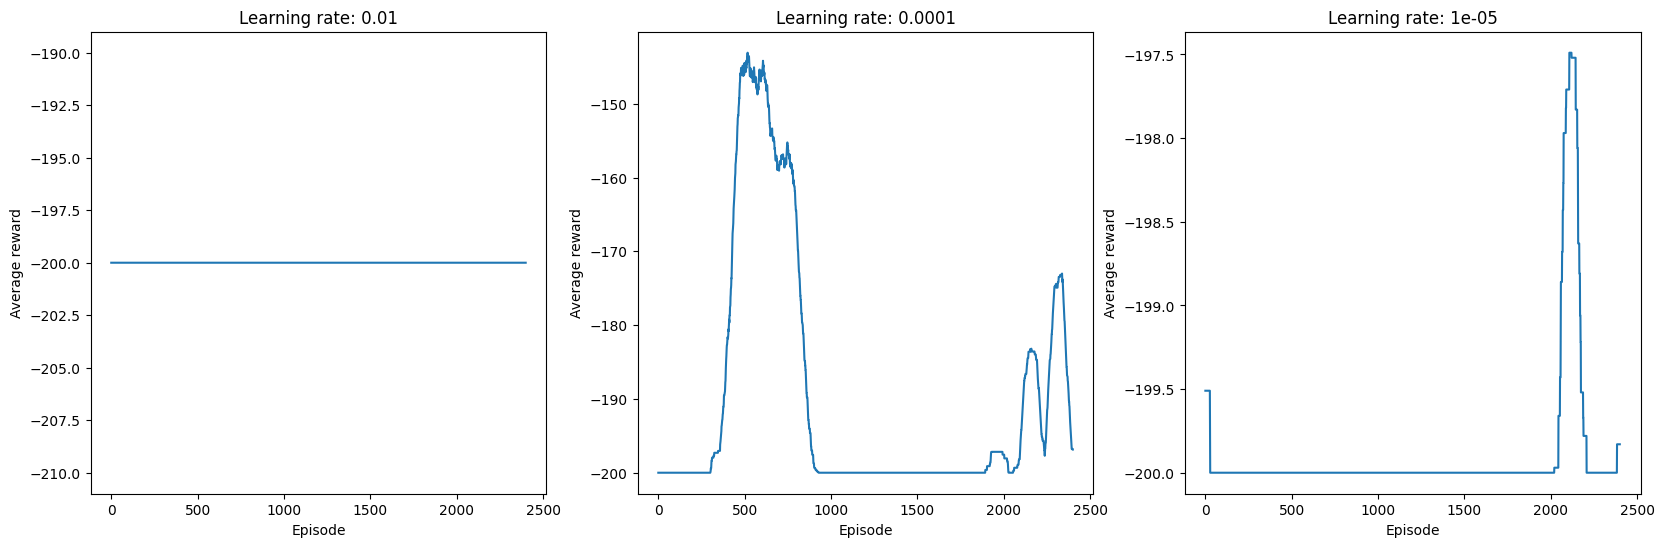

In [23]:
# Plot everything!
window_size = 100

rewards_1, rewards_2, rewards_3 = all_experiment_rewards

average_rewards_1 = [sum(rewards_1[i:i+window_size])/window_size for i in range(len(rewards_1)-window_size)]
average_rewards_2 = [sum(rewards_2[i:i+window_size])/window_size for i in range(len(rewards_2)-window_size)]
average_rewards_3 = [sum(rewards_3[i:i+window_size])/window_size for i in range(len(rewards_3)-window_size)]

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, rewards in enumerate([average_rewards_1, average_rewards_2, average_rewards_3]):
    ax[i].plot(rewards)
    ax[i].set_title(f'Learning rate: {lrs[i]}')
    ax[i].set_xlabel('Episode')
    ax[i].set_ylabel('Average reward')


It is clear from the plots above that a learning rate can either be too high or too low. For this specific problem, and with the other hyperparameters fixed, 1e-3 - 1e-4 seems to be a sweet spot!